# Himmelblau Benchmark with outliers
## Imports

In [ ]:
import os
from functools import partial

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import bofire.strategies.api as strategies
from bofire.benchmarks.benchmark import UniformOutlierPrior
from bofire.benchmarks.single import Himmelblau
from bofire.data_models.acquisition_functions.api import qLogEI
from bofire.data_models.domain.api import Domain, Outputs
from bofire.data_models.features.api import CategoricalInput
from bofire.data_models.outlier_detection.api import (
    IterativeTrimming,
    OutlierDetections,
)
from bofire.data_models.strategies.api import RandomStrategy, SoboStrategy
from bofire.data_models.surrogates.api import (
    MixedSingleTaskGPSurrogate,
    SingleTaskGPSurrogate,
)
from bofire.runners.api import run


SMOKE_TEST = os.environ.get("SMOKE_TEST")

## sample set of Himmelblau example to start optimization
we use the same set of example as initial data for comparision of three models. One case is where there is no outlier, while for other two models, we introduced outliers at a fixed probability. Using same initial example data helps us to compare the efficiency of outlier detection compared to the no outlier model that works on the dataset with no outliers. Further, using same sampled set with same outliers help starting both models with and without outlier detection from same value and we can see their evolution with iterations.

In [ ]:
def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled


def best(domain: Domain, experiments: pd.DataFrame) -> float:
    return experiments.y.min()


bo_results_set = []  # stores progress of model on data with no outliers (no outliers model)
bo_results_outliers_set = []  # stores progress of model with no outlier detection on data with outliers (baseline model)
bo_results_no_outliers_set = []  # stores progress of model with the outlier detection on data with outliers (our model)

Benchmark = Himmelblau()
sampled = sample(Benchmark.domain)
sampled_xy = Benchmark.f(sampled, return_complete=True)

# Adding outliers
Here we show an example of adding outliers with uniform priors between range of 50 and 100. We consider three cases of outliers; outliers not outrageous with range of 50 to 100, outliers moderately outrageous with range of 500 to 1000 and outliers too outrageous with brange of 5000 to 10000. The model should detect the more outrageous outliers easily and vice versa. Here is an example of not outrageous outlier addition with a probability of 0.2

In [ ]:
Benchmark = Himmelblau(
    outlier_rate=0.2, outlier_prior=UniformOutlierPrior(bounds=(50, 100))
)  # not outrageous
sampled_xy1 = Benchmark.f(sampled, return_complete=True)

# Outliers not outrageous
Now we run optimization to compare the three models for not outrageous outliers.

In [ ]:
bo_results_set = []
bo_results_outliers_set = []
bo_results_no_outliers_set = []
n_iterations = 10 if not SMOKE_TEST else 1


def sobo_factory(domain: Domain):
    return strategies.map(SoboStrategy(domain=domain, acquisition_function=qLogEI()))


def sobo_factory_outlier(domain: Domain, outlier_detection_specs: OutlierDetections):
    return strategies.map(
        SoboStrategy(
            domain=domain,
            acquisition_function=qLogEI(),
            outlier_detection_specs=outlier_detection_specs,
            min_experiments_before_outlier_check=10,
            frequency_check=2,
        )
    )


for _kk in range(n_iterations):
    Benchmark = Himmelblau()
    sampled = sample(Benchmark.domain)
    sampled_xy = Benchmark.f(sampled, return_complete=True)
    random_results = run(
        Himmelblau(),
        strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=domain)),
        n_iterations=50,  # random strategy
        metric=best,
        initial_sampler=sampled_xy,
        n_runs=1,
        n_procs=1,
    )

    bo_results = run(
        Himmelblau(),
        strategy_factory=sobo_factory,
        n_iterations=50 if not SMOKE_TEST else 1,
        metric=best,
        initial_sampler=sampled_xy,
        n_runs=1,
        n_procs=1,
    )

    Benchmark = Himmelblau(
        outlier_rate=0.2, outlier_prior=UniformOutlierPrior(bounds=(50, 100))
    )
    sampled_xy1 = Benchmark.f(sampled, return_complete=True)

    bo_results_outliers = run(
        Benchmark,
        strategy_factory=sobo_factory,
        n_iterations=50 if not SMOKE_TEST else 1,
        metric=best,
        initial_sampler=sampled_xy1,
        n_runs=1,
        n_procs=1,
    )

    domain = Benchmark.domain

    detectors = []
    for output_feature in domain.outputs.get_keys():
        if len(domain.inputs.get(CategoricalInput, exact=True)):
            detectors.append(
                IterativeTrimming(
                    base_gp=MixedSingleTaskGPSurrogate(
                        inputs=domain.inputs,
                        outputs=Outputs(
                            features=[domain.outputs.get_by_key(output_feature)]
                        ),  # type: ignore
                    )
                )
            )
        else:
            detectors.append(
                IterativeTrimming(
                    base_gp=SingleTaskGPSurrogate(
                        inputs=domain.inputs,
                        outputs=Outputs(
                            features=[domain.outputs.get_by_key(output_feature)]
                        ),  # type: ignore
                    )
                )
            )
    outlier_detection_specs = OutlierDetections(detectors=detectors)

    bo_results_no_outliers = run(
        Benchmark,
        strategy_factory=partial(
            sobo_factory_outlier, outlier_detection_specs=outlier_detection_specs
        ),
        n_iterations=50 if not SMOKE_TEST else 1,
        metric=best,
        initial_sampler=sampled_xy1,
        n_runs=1,
        n_procs=1,
    )

    bo_results_set.append(bo_results[0])
    bo_results_outliers_set.append(bo_results_outliers[0])
    bo_results_no_outliers_set.append(bo_results_no_outliers[0])

## Collecting data evolution over iterations

bo_results_itr = np.zeros((len(bo_results_set), 50))
bo_results_outliers_itr = np.zeros((len(bo_results_set), 50))
bo_results_no_outliers_itr = np.zeros((len(bo_results_set), 50))
for i in range(len(bo_results_set)):
    bo_results_itr[i] = bo_results_set[i][1].to_numpy()
    bo_results_outliers_itr[i] = bo_results_outliers_set[i][1].to_numpy()
    bo_results_no_outliers_itr[i] = bo_results_no_outliers_set[i][1].to_numpy()

Run 0: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it, Current Best:=0.274]


### Performance of models

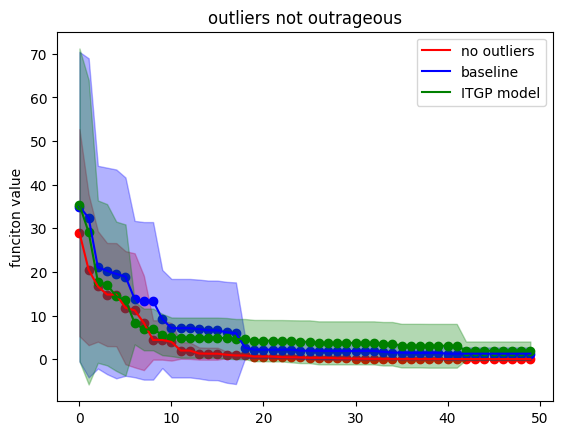

In [ ]:
if not SMOKE_TEST:
    plt.plot(bo_results_itr.mean(axis=0), color="red", label="no outliers")
    plt.scatter(range(50), bo_results_itr.mean(axis=0), color="red")
    plt.fill_between(
        range(50),
        (bo_results_itr.mean(axis=0) - bo_results_itr.std(axis=0)),
        (bo_results_itr.mean(axis=0) + bo_results_itr.std(axis=0)),
        alpha=0.3,
        color="red",
    )
    plt.plot(bo_results_outliers_itr.mean(axis=0), color="blue", label="baseline")
    plt.scatter(range(50), bo_results_outliers_itr.mean(axis=0), color="blue")
    plt.fill_between(
        range(50),
        (bo_results_outliers_itr.mean(axis=0) - bo_results_outliers_itr.std(axis=0)),
        (bo_results_outliers_itr.mean(axis=0) + bo_results_outliers_itr.std(axis=0)),
        alpha=0.3,
        color="blue",
    )
    plt.plot(bo_results_no_outliers_itr.mean(axis=0), color="green", label="ITGP model")
    plt.scatter(range(50), bo_results_no_outliers_itr.mean(axis=0), color="green")
    plt.fill_between(
        range(50),
        (
            bo_results_no_outliers_itr.mean(axis=0)
            - bo_results_no_outliers_itr.std(axis=0)
        ),
        (
            bo_results_no_outliers_itr.mean(axis=0)
            + bo_results_no_outliers_itr.std(axis=0)
        ),
        alpha=0.3,
        color="green",
    )

    plt.ylabel("funciton value")
    # plt.yscale('log',base=10)
    plt.legend()
    plt.title("outliers not outrageous")
    plt.show()

# Outliers moderately outrageous
Now we run optimization to compare the three models for moderately outrageous outliers.

In [ ]:
bo_results_set = []
bo_results_outliers_set = []
bo_results_no_outliers_set = []
n_iterations = 10 if not SMOKE_TEST else 1

for _kk in range(n_iterations):
    Benchmark = Himmelblau()
    sampled = sample(Benchmark.domain)
    sampled_xy = Benchmark.f(sampled, return_complete=True)
    random_results = run(
        Himmelblau(),
        strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=domain)),
        n_iterations=50,  # random strategy
        metric=best,
        initial_sampler=sampled_xy,
        n_runs=1,
        n_procs=1,
    )

    bo_results = run(
        Himmelblau(),
        strategy_factory=sobo_factory,
        n_iterations=50 if not SMOKE_TEST else 1,
        metric=best,
        initial_sampler=sampled_xy,
        n_runs=1,
        n_procs=1,
    )

    Benchmark = Himmelblau(
        outlier_rate=0.2, outlier_prior=UniformOutlierPrior(bounds=(500, 1000))
    )
    sampled_xy1 = Benchmark.f(sampled, return_complete=True)

    bo_results_outliers = run(
        Benchmark,
        strategy_factory=sobo_factory,
        n_iterations=50 if not SMOKE_TEST else 1,
        metric=best,
        initial_sampler=sampled_xy1,
        n_runs=1,
        n_procs=1,
    )

    domain = Benchmark.domain
    detectors = []
    for output_feature in domain.outputs.get_keys():
        if len(domain.inputs.get(CategoricalInput, exact=True)):
            detectors.append(
                IterativeTrimming(
                    base_gp=MixedSingleTaskGPSurrogate(
                        inputs=domain.inputs,
                        outputs=Outputs(
                            features=[domain.outputs.get_by_key(output_feature)]
                        ),  # type: ignore
                    )
                )
            )
        else:
            detectors.append(
                IterativeTrimming(
                    base_gp=SingleTaskGPSurrogate(
                        inputs=domain.inputs,
                        outputs=Outputs(
                            features=[domain.outputs.get_by_key(output_feature)]
                        ),  # type: ignore
                    )
                )
            )
    outlier_detection_specs = OutlierDetections(detectors=detectors)

    bo_results_no_outliers = run(
        Benchmark,
        strategy_factory=partial(
            sobo_factory_outlier, outlier_detection_specs=outlier_detection_specs
        ),
        n_iterations=50 if not SMOKE_TEST else 1,
        metric=best,
        initial_sampler=sampled_xy1,
        n_runs=1,
        n_procs=1,
    )

    bo_results_set.append(bo_results[0])
    bo_results_outliers_set.append(bo_results_outliers[0])
    bo_results_no_outliers_set.append(bo_results_no_outliers[0])

## Collecting data evolution over iterations

bo_results_itr = np.zeros((len(bo_results_set), 50))
bo_results_outliers_itr = np.zeros((len(bo_results_set), 50))
bo_results_no_outliers_itr = np.zeros((len(bo_results_set), 50))
for i in range(len(bo_results_set)):
    bo_results_itr[i] = bo_results_set[i][1].to_numpy()
    bo_results_outliers_itr[i] = bo_results_outliers_set[i][1].to_numpy()
    bo_results_no_outliers_itr[i] = bo_results_no_outliers_set[i][1].to_numpy()

Run 0: 100%|██████████| 50/50 [00:51<00:00,  1.02s/it, Current Best:=0.667]


## Performance of models

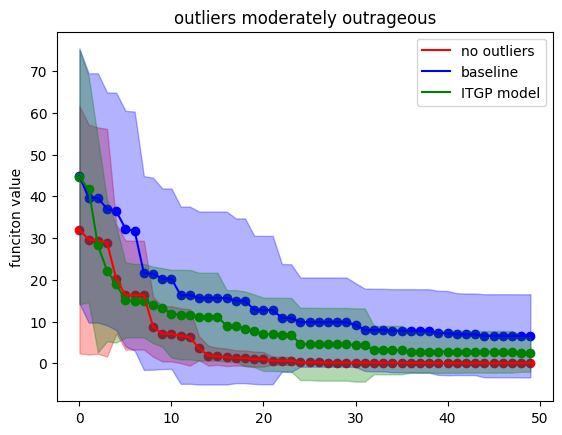

In [ ]:
if not SMOKE_TEST:
    plt.plot(bo_results_itr.mean(axis=0), color="red", label="no outliers")
    plt.scatter(range(50), bo_results_itr.mean(axis=0), color="red")
    plt.fill_between(
        range(50),
        (bo_results_itr.mean(axis=0) - bo_results_itr.std(axis=0)),
        (bo_results_itr.mean(axis=0) + bo_results_itr.std(axis=0)),
        alpha=0.3,
        color="red",
    )
    plt.plot(bo_results_outliers_itr.mean(axis=0), color="blue", label="baseline")
    plt.scatter(range(50), bo_results_outliers_itr.mean(axis=0), color="blue")
    plt.fill_between(
        range(50),
        (bo_results_outliers_itr.mean(axis=0) - bo_results_outliers_itr.std(axis=0)),
        (bo_results_outliers_itr.mean(axis=0) + bo_results_outliers_itr.std(axis=0)),
        alpha=0.3,
        color="blue",
    )
    plt.plot(bo_results_no_outliers_itr.mean(axis=0), color="green", label="ITGP model")
    plt.scatter(range(50), bo_results_no_outliers_itr.mean(axis=0), color="green")
    plt.fill_between(
        range(50),
        (
            bo_results_no_outliers_itr.mean(axis=0)
            - bo_results_no_outliers_itr.std(axis=0)
        ),
        (
            bo_results_no_outliers_itr.mean(axis=0)
            + bo_results_no_outliers_itr.std(axis=0)
        ),
        alpha=0.3,
        color="green",
    )

    plt.ylabel("funciton value")
    # plt.yscale('log',base=10)
    plt.legend()
    plt.title("outliers moderately outrageous")
    plt.show()

# Outliers too outrageous
Now we run optimization to compare the three models for too outrageous outliers.

In [ ]:
bo_results_set = []
bo_results_outliers_set = []
bo_results_no_outliers_set = []
n_iterations = 10 if not SMOKE_TEST else 1
for _kk in range(n_iterations):
    Benchmark = Himmelblau()
    sampled = sample(Benchmark.domain)
    sampled_xy = Benchmark.f(sampled, return_complete=True)
    random_results = run(
        Himmelblau(),
        strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=domain)),
        n_iterations=50,  # random strategy
        metric=best,
        initial_sampler=sampled_xy,
        n_runs=1,
        n_procs=1,
    )

    bo_results = run(
        Himmelblau(),
        strategy_factory=sobo_factory,
        n_iterations=50 if not SMOKE_TEST else 1,
        metric=best,
        initial_sampler=sampled_xy,
        n_runs=1,
        n_procs=1,
    )

    Benchmark = Himmelblau(
        outlier_rate=0.2, outlier_prior=UniformOutlierPrior(bounds=(5000, 10000))
    )
    sampled_xy1 = Benchmark.f(sampled, return_complete=True)

    bo_results_outliers = run(
        Benchmark,
        strategy_factory=sobo_factory,
        n_iterations=50 if not SMOKE_TEST else 1,
        metric=best,
        initial_sampler=sampled_xy1,
        n_runs=1,
        n_procs=1,
    )

    domain = Benchmark.domain
    detectors = []
    for output_feature in domain.outputs.get_keys():
        if len(domain.inputs.get(CategoricalInput, exact=True)):
            detectors.append(
                IterativeTrimming(
                    base_gp=MixedSingleTaskGPSurrogate(
                        inputs=domain.inputs,
                        outputs=Outputs(
                            features=[domain.outputs.get_by_key(output_feature)]
                        ),  # type: ignore
                    )
                )
            )
        else:
            detectors.append(
                IterativeTrimming(
                    base_gp=SingleTaskGPSurrogate(
                        inputs=domain.inputs,
                        outputs=Outputs(
                            features=[domain.outputs.get_by_key(output_feature)]
                        ),  # type: ignore
                    )
                )
            )
    outlier_detection_specs = OutlierDetections(detectors=detectors)

    bo_results_no_outliers = run(
        Benchmark,
        strategy_factory=partial(
            sobo_factory_outlier, outlier_detection_specs=outlier_detection_specs
        ),
        n_iterations=50 if not SMOKE_TEST else 1,
        metric=best,
        initial_sampler=sampled_xy1,
        n_runs=1,
        n_procs=1,
    )

    bo_results_set.append(bo_results[0])
    bo_results_outliers_set.append(bo_results_outliers[0])
    bo_results_no_outliers_set.append(bo_results_no_outliers[0])

## Collecting data evolution over iterations

bo_results_itr = np.zeros((len(bo_results_set), 50))
bo_results_outliers_itr = np.zeros((len(bo_results_set), 50))
bo_results_no_outliers_itr = np.zeros((len(bo_results_set), 50))
for i in range(len(bo_results_set)):
    bo_results_itr[i] = bo_results_set[i][1].to_numpy()
    bo_results_outliers_itr[i] = bo_results_outliers_set[i][1].to_numpy()
    bo_results_no_outliers_itr[i] = bo_results_no_outliers_set[i][1].to_numpy()

Run 0:  74%|███████▍  | 37/50 [00:33<00:14,  1.14s/it, Current Best:=0.044]/Users/radical-rhys/miniconda/lib/python3.12/site-packages/botorch/optim/optimize.py:568: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
Run 0: 100%|██████████| 50/50 [01:15<00:00,  1.50s/it, Current Best:=1.461] 


## Performance of models

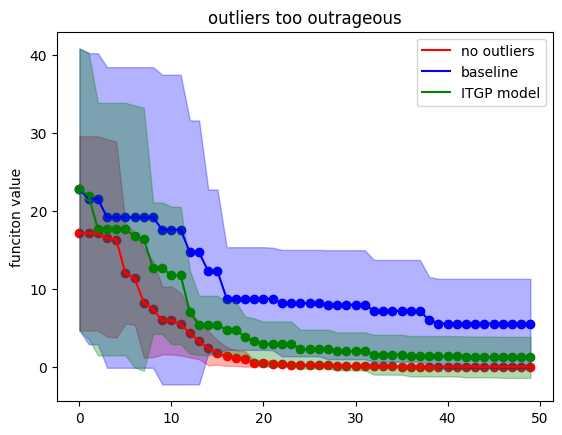

In [ ]:
if not SMOKE_TEST:
    plt.plot(bo_results_itr.mean(axis=0), color="red", label="no outliers")
    plt.scatter(range(50), bo_results_itr.mean(axis=0), color="red")
    plt.fill_between(
        range(50),
        (bo_results_itr.mean(axis=0) - bo_results_itr.std(axis=0)),
        (bo_results_itr.mean(axis=0) + bo_results_itr.std(axis=0)),
        alpha=0.3,
        color="red",
    )
    plt.plot(bo_results_outliers_itr.mean(axis=0), color="blue", label="baseline")
    plt.scatter(range(50), bo_results_outliers_itr.mean(axis=0), color="blue")
    plt.fill_between(
        range(50),
        (bo_results_outliers_itr.mean(axis=0) - bo_results_outliers_itr.std(axis=0)),
        (bo_results_outliers_itr.mean(axis=0) + bo_results_outliers_itr.std(axis=0)),
        alpha=0.3,
        color="blue",
    )
    plt.plot(bo_results_no_outliers_itr.mean(axis=0), color="green", label="ITGP model")
    plt.scatter(range(50), bo_results_no_outliers_itr.mean(axis=0), color="green")
    plt.fill_between(
        range(50),
        (
            bo_results_no_outliers_itr.mean(axis=0)
            - bo_results_no_outliers_itr.std(axis=0)
        ),
        (
            bo_results_no_outliers_itr.mean(axis=0)
            + bo_results_no_outliers_itr.std(axis=0)
        ),
        alpha=0.3,
        color="green",
    )

    plt.ylabel("funciton value")
    # plt.yscale('log',base=10)
    plt.legend()
    plt.title("outliers too outrageous")
    plt.show()